卷积神经网络之卷积层
===

接下来我将会介绍卷积层、池化层、正则化层、Dropout层、激活层、全连接层、损失函数的前向算法、后向算法以及梯度计算，我们使用的是$224,224,3$的图片

# 1.卷积层的意义
卷积层只要是为了提取图片的特征，它传统神经网络的优势在于可以有效的减少计算量。卷积层的输入时上一层所输出的特征图。

# 2.卷积层的特点
- 局部连接：这个是最容易想到的，每个神经元不再和上一层的所有神经元相连，而只和一小部分神经元相连。这样就减少了很多参数。
- 权值共享：一组连接可以共享同一个权重，而不是每个连接有一个不同的权重，这样又减少了很多参数。
- 下采样：可以使用Pooling来减少每层的样本数，进一步减少参数数量，同时还可以提升模型的鲁棒性。

# 3.卷积层的关键参数
- 输入通道：即输入数据的神经元个数
- 输出通道：即输出数据的神经元个数
- 卷积核大小：即参与操作的卷积核的大小
- 步长：即没做完一步操作，需要跨几个像素去寻找下一个卷积核
- 是否需要扩充图片

# 4.卷积的效果图
我们可以先看一下用纯numpy实现的一个卷积层的效果

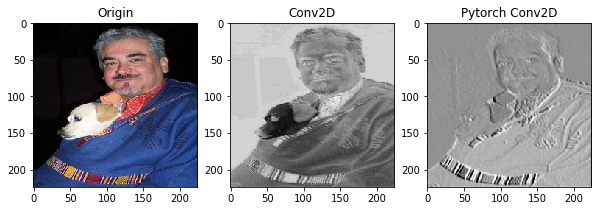

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torchvision.models as models
import torch
import JLib.pyn.cnn.python_layer as epcl
import JLib.pyn.cnn.functions as epcf

plt.figure(figsize=(10,10), facecolor='w')
imagePath = "data/ConvVisible01.jpg"
img = cv2.imread(imagePath)
basicImage = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
originImg = cv2.resize(basicImage, (224,224))
plt.subplot(1,3,1)
plt.title('Origin')
plt.imshow(originImg)

conv1 = epcl.Conv2D(3, 64, 3, 1, 'SAME')
img = epcf.preprocess_image(basicImage).transpose((0, 2, 3, 1))
features = conv1(img)
feature = features[:, :, :,0]
feature = np.reshape(feature, newshape=(feature.shape[1], feature.shape[2]))
feature = 1.0 / (1 + np.exp(-1 * feature))
feature = np.round(feature * 255)
plt.subplot(1,3,2)
plt.title('Conv2D')
plt.imshow(feature, cmap='gray')

model = models.vgg16(pretrained=True).features
img = epcf.preprocess_image(basicImage)
features = model[0](torch.autograd.Variable(torch.FloatTensor(img)))
feature = features[:, 0, :, :]
feature = feature.view(feature.shape[1], feature.shape[2])
feature = feature.data.numpy()
feature = 1.0 / (1 + np.exp(-1 * feature))
feature = np.round(feature * 255)
plt.subplot(1,3,3)
plt.title('Pytorch Conv2D')
plt.imshow(feature, cmap='gray')

![Images](Images/05_02_001.jpg)

我们可以直观的看到原图和经过一层卷积之后的效果图的比较，下面我们来介绍如何进行卷积层具体的操作，也就是平时我们所说的前向算法

注：之所以后两张图差别较大，是因为我们的卷积层所用到的权重是没有经过训练的，而后一个是经过训练之后的权重。并且由于我们的权重初始化是随机的，所以每次运行的效果可能都不同

# 5.卷积层的前向算法-forward
卷积层的前向计算就是进行卷积计算的过程，我们知道下一个神经元的输出就是
$$\phi_i=\omega_i \bullet x + b$$
对于整个特征图来说，就是
$$\vec{\Phi}=\vec{\omega} \bullet \vec{x}+\vec{b}$$
假设我们的输入特征图为$bs,224,224, 3$(bs为图片张数,224为尺寸大小,3为通道数-RGB)，输出神经元output_channel=64，卷积核大小ksize=3，步长strid=1，补齐，name最终输出的结果就应该是$bs,224,224,64$

上图的意思是，有一个大小为$(3 \times 3 \times 3)$的特征图，要跟两个大小为$(2 \times 2 \times 3)$的卷积核做卷积计算。特征图三通道如下
$$
R=\begin{bmatrix}
1&2&0 \\
1&1&3 \\
0&2&2
\end{bmatrix}G=\begin{bmatrix}
0&2&1 \\
0&3&2 \\
1&1&0
\end{bmatrix}B=\begin{bmatrix}
1&2&1 \\
0&1&3 \\
3&3&2
\end{bmatrix}
$$
两个卷积核如下
$$
\begin{bmatrix}
1&1 \\
2&2
\end{bmatrix}\begin{bmatrix}
1&1 \\
1&1
\end{bmatrix}\begin{bmatrix}
0&1 \\
1&0
\end{bmatrix}，\begin{bmatrix}
1&0 \\
0&1
\end{bmatrix}\begin{bmatrix}
2&1 \\
2&1
\end{bmatrix}\begin{bmatrix}
1&2 \\
2&0
\end{bmatrix}
$$

我们先看上半部分的Traditional Convolution部分，由于卷积核是$2 \times 2$的，所有特征图也需要用$2 \times 2$的部分循环与卷积核进行卷积操作。

然后我们看下半部分Matrix Product Version of Convolution。第一步先将R通道的$3 \times 3$的矩阵，按照卷积核的大小变换为$4 \times 4$的矩阵，这个变换可以从图上很容易看出来，接着变换G和B通道，同时将卷积核也同样做相应的变换。最后就可以变为两个矩阵的点乘。于是就有了下面的前向算法

卷计算法真正的核心是函数_im2col

In [ ]:
def _im2col(image, ksize, stride):
    # image is a 4d tensor([batchsize, width ,height, channel])
    image_col = []
    for i in range(0, image.shape[1] - ksize + 1, stride):
        for j in range(0, image.shape[2] - ksize + 1, stride):
            col = image[:, i:i + ksize, j:j + ksize, :].reshape([-1])
            image_col.append(col)
    image_col = np.array(image_col)

    return image_col

输入image是单张图片的数据，这里应该是$226,226,3$,ksize=3,stride=1,循环行与列，每次取到一个#3,3,3#的图像区块数据，然后reshape到一维，也就是$(27)$，然后将所有的卷积结果放在一起转化为array，就目前来说，结果是
$$((226-3+1) * (226-3+1), 27)=(50176, 27)$$
相当于最后得到了50176块图像区块，每个区块的大小为27维。这里为何是226呢，这是因为我们选择了补齐，所以卷积之前或对图片进行扩充。
接下来我们需要做的就是
$$\vec{\Phi}=\vec{\omega} \bullet \vec{x}+\vec{b}$$
如果是第一次调用，那么我们默认会对权重和偏执进行初始化，我们使用的是MSRA初始化。

In [ ]:
col_image_i = None
col_weights = None
bias = None
np.dot(col_image_i, col_weights) + bias

col_image_i就是我们上面的卷积的结果，$shape=50176,27$，col_weights是权重，$shape=(27,64)$，bias是偏执，$shape=(64)$，64就是输出神经元的个数，然后将结果reshape成$1,224,224,64$，然后放入一个数组

最后bs次，计算出这一批次所有的图片的卷积，合并在一起，reshape成$bs,224,224,64$

# 6.卷积层的梯度计算-gradient

# 7.卷积层的后向算法-backward

# 8.$3 \times 3$卷积
使用用$3 \times 3$卷积来替代更大尺寸的卷积，那么有一个前提，就是要保证两者具有同样大小的输出和感受野。两个$3 \times 3$的卷积才能代替一个$5 \times 5$的卷积；三个$3 \times 3$的卷积才能代替一个$7 \times 7$的卷积。

使用$3 \times 3$的卷积的好处
- 网络层数增加了，这增加了网络的非线性表达能力。
- 参数变少了，两个$3 \times 3$和一个$5 \times 5$的参数比例为3×3×2/(5×5)=0.72，同样的三个$3 \times 3$和一个$7 \times 7$参数比例为3×3×3/(7×7)=0.55，将近一倍的压缩，这可是很大提升。

# 9.$1 \times 1$卷积
![image](Images/05_02_002.jpeg)
- 实现了不同通道同一位置的信息融合，如上图，C2融合了C1不同通道同一位置的信息。
- 可以实现通道数的降维或升维。$1 \times 1 \times n$，如果n小于之前通道数，则实现了降维，如果n大于之前通道数，则实现了升维。

# 10.CNN中的卷积核设计原则
- 卷积核的大小一般是奇数
- 卷积核所有的元素之和一般要等于1，这是为了原始图像的能量守恒
- 如果滤波器矩阵所有元素之和大于1，那么滤波后的图像就会比原图像更亮